
## Preliminaries 

In [2]:
#basics 
import os
import glob

# scientific computing
import numpy as np
import scipy
from scipy import misc
import scipy.signal

# sklearn
from sklearn.model_selection import train_test_split

# plotting
import matplotlib.pyplot as plt
import utils.util as util
%matplotlib inline

# tensorflow
import tensorflow as tf

# keras
import keras
from keras.preprocessing import image # requires PIL 
from keras import backend as K
from keras.utils import np_utils

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

from imp import reload



# From MLP's to Conv Nets... 




<div>
<h3 align="center">Multilayer Perceptrons</h3>
<img src="imgs/neural_net2.jpeg" style="width: 500px;"/>

<h3 align="center">.. to Deep Convolutional Nets</h3>

<img src="imgs/alexnet.jpeg" style="width: 800px;"/>
</div>

### What's wrong with MLP's?  
- Regular Neural Nets don’t scale well to full images
- A 200x200x3 image would require ~120,000 weights for the first layer!

### Some obvious Differences

- **convolutional layers** 
- **pooling layers** 
- layers now have 3 dimensions instead of 1! (We'll get to that below) 

## Convolution in 2-D and Spatial Filters



In [2]:
# load in an image that comes with Scipy
rawIm = misc.face(gray=True)[:500,300:]

# pre-processing
im = (rawIm - np.mean(rawIm))/np.std(rawIm)
im = scipy.ndimage.gaussian_filter(im,1)

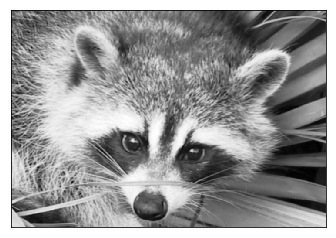

In [3]:
plt.imshow(im,cmap='Greys_r',interpolation='nearest'); util.removeAxes(plt.gca())

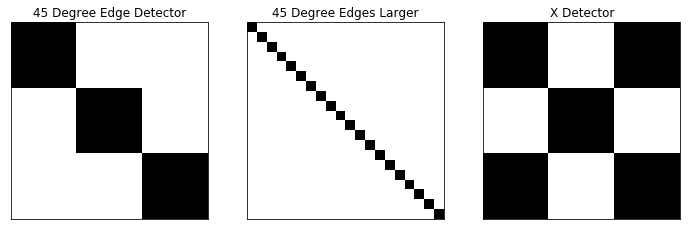

In [4]:
# Define some edge-detecting image kernels
# make sure they add up/integrate to 0

diagEdgeDetection1 = np.eye(3)
diagEdgeDetection1 = -1*(diagEdgeDetection1-diagEdgeDetection1.mean())/np.std(diagEdgeDetection1)

diagEdgeDetection2 = np.eye(20)
diagEdgeDetection2 = -1*(diagEdgeDetection2-diagEdgeDetection2.mean())/np.std(diagEdgeDetection2)

XDetection = np.eye(3)+np.rot90(np.eye(3))
XDetection[1,1]=1
XDetection = -1*(XDetection-XDetection.mean())/np.std(XDetection)

kernels = [diagEdgeDetection1,diagEdgeDetection2,XDetection]
kernelNames = ["45 Degree Edge Detector","45 Degree Edges Larger","X Detector"]
numKernels = len(kernels)

signals = [im]
signalNames = ["Original","45 Degree Edges","45 Degree Edges Larger", "X Detector"]

# Plot 
plt.figure(figsize=(12,4));
for idx,(kernel,name) in enumerate(zip(kernels,kernelNames)):
    signals.append(scipy.signal.convolve2d(signals[0],kernel))
    plt.subplot(1,numKernels,idx+1); plt.title(name)
    plt.imshow(kernel,interpolation='nearest',cmap="Greys_r");util.removeAxes(plt.gca())

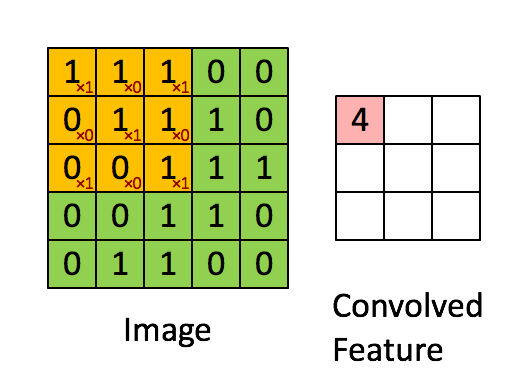

In [5]:
from IPython.display import Image
Image(filename="./imgs/conv_gif copy.gif.png")

- The convolution operation takes a filter, moves it around the image, and sum s up the response to the filter at each point in the image.
- Results in a features map 
- Smaller in size: (size of image) - (size of filter-1) 


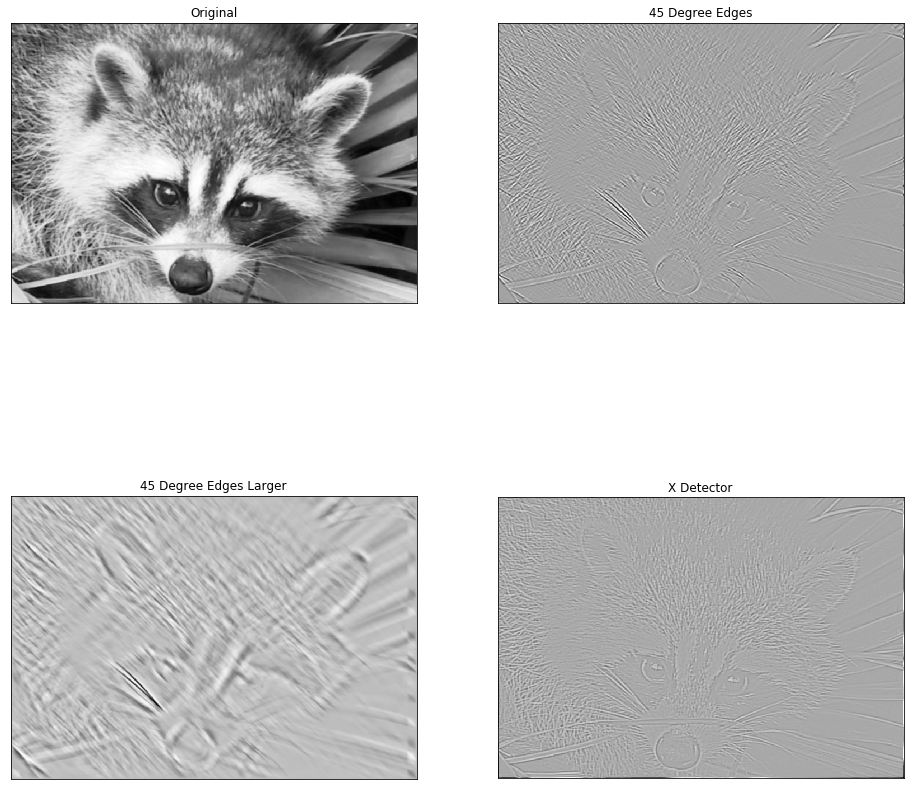

In [6]:
plt.figure(figsize=(16,16)); numSignals = len(signals)
cmaps = ['Greys_r','Greys_r','Greys_r','Greys_r'];

for idx,(signal,name) in enumerate(zip(signals,signalNames)):
    plt.subplot(2,numSignals//2,idx+1); plt.title(name)
    plt.imshow(signal,cmap=cmaps[idx],interpolation='nearest'); util.removeAxes(plt.gca())

- the resulting signal (image) is often called a *feature map* in contemporary machine learning. 
- They are linear, invariant transforms. 
- Hence why we often add a non-linear transform on top

# Convolutional Layers

## from 1D to 3D Layers!. 
<p>In MLP's the input is squashed into 1-D</p>
<img src="imgs/neural_net2.jpeg" style="width: 500px;"/>
<p>In convnets, the input remains a 3D image (2D + color)</p>
<img src="imgs/cnn.jpeg" style="width: 500px;"/>


## Receptive Fields and Learnable Filters 

- Within each "depth" column, neurons have the same receptive field.
- Within the receptive field, the neuron's weights act like the filters we applied to the Racoon above. 
- Each neuron in the "depth" column learns a different filter to use on the same part of the image.  
- The size of the receptive field is a parameter of the layer, as is the depth of layer. 

<img src="imgs/depthcol.jpeg" style="width: 400px;"/>


## Weight sharing and Convolution 

> If all neurons in a single depth slice are using the same weight vector, then the forward pass of the CONV layer can in each depth slice be computed as a convolution of the neuron’s weights with the input volume (Hence the name: Convolutional Layer). This is why it is common to refer to the sets of weights as a filter (or a kernel), that is convolved with the input. ~ CS231


### Why share weights? 

- reduces the amount of parameters to learn
- images consist of the same features in different locations. In other words, sharing weights allows the network to learn features in a location invariant way. 

### Variants 

- **Locally connected layers** are a variant where weights are only shared among nearby neurons. 
- The neurons in the center might learn different features than the ones in the periphery. 
- Useful for centered images like those containing faces etc.  

# Pooling Layers


<p>
<ul>
<li> Pooling layers are used to reduce the dimensions of the feature images, thus reducing the number of parameters needed in higher levels. 
<li> Modeled after the visual system, in which the receptive fields of images get larger. 
</ul>
</p>

<img src="imgs/pool1.jpeg" style="width: 400px;"/>

- Max pooling is often used. Max pooling essentially asks whether the features (for each depth layer) is present anywhere in the area pooled across

<img src="imgs/maxpool.jpeg" style="width: 400px;"/>


# Trying it Out on Digits! 

(I tried it first on fisheries.. way to complicated images)


## Using TensorFlow

### Load and Preprocess the data 

In [3]:
# load the mnist dataset
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

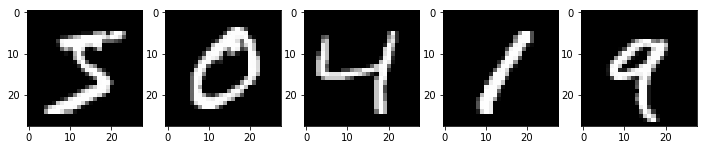

In [4]:
# plot some data 
util.plot_across([X_train[i,:,:,0] for i in range(5)])


In [5]:
# notice the shape 
print(X_train.shape)

(60000, 28, 28, 1)


In [6]:
# scaling the input values (networks work better with normalized input)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [7]:
# One-hot coding of the labels 
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
Y_train[1:5,:]

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [8]:
print(Y_train.shape)

(60000, 10)


### Build the network

In [9]:
# create a tensorflow session
session = tf.InteractiveSession()

In [10]:
# place holder for input (will be filled in with actual data during run time)
input_layer = tf.placeholder(dtype=tf.float32,shape=[None,X_train.shape[1],X_train.shape[2],1])

In [11]:
# Convolutional Layer #1
conv1 = tf.layers.conv2d(
  inputs=input_layer,
  filters=32,
  kernel_size=[5, 5],
  padding="same",
  activation=tf.nn.relu)

In [12]:
# Pooling Layer #1
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

In [13]:
# Convolutional Layer #1
conv2 = tf.layers.conv2d(
  inputs=pool1,
  filters=32,
  kernel_size=[5, 5],
  padding="same",
  activation=tf.nn.relu)

In [14]:
# Pooling Layer #2 
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
print(pool2)

Tensor("max_pooling2d_2/MaxPool:0", shape=(?, 7, 7, 32), dtype=float32)


In [15]:
# Dense (Fully-Connected) Layer 
pool2_flat = tf.reshape(pool2, [-1,7*7*32]) # for digits 
dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

# Potentially add some drop out during training
##dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

In [16]:
# Output layer 
logits = tf.layers.dense(inputs=dense, units=10) # digits 

In [17]:
# place holders for labels 
sy_labels = tf.placeholder(tf.int32,shape=[None])

# place holders for one-hot labels 
onehot_labels = tf.placeholder(tf.int32,shape=[None,10]) # digits

In [18]:
# define loss function for training 
loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits=logits)

# define optimization algorithm and bind to the loss function 


#optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)

optimizer = tf.train.AdamOptimizer() # works much better for this dataset... 

train_op = optimizer.minimize(loss=loss,global_step=tf.train.get_global_step())

In [19]:
# define some other output for the network for calculation accuracy  
sy_classes = tf.argmax(input=logits, axis=1)
probabilities = tf.nn.softmax(logits, name="softmax_tensor")

In [20]:
# Initialize all the variables and build the tensorflow graph. 
session.run(tf.global_variables_initializer())

### Train the Network

In [21]:
# run batch gradient descent
batchsize =100
accuracies = []
for step in range(1000): # employed early stopping (by mistake)
    
    # choose batch 
    idx = np.random.choice(range(np.shape(X_train)[0]),batchsize,replace=False)
    X_batch = X_train[idx,]
    Y_batch = Y_train[idx,]
    y_batch = np.argmax(Y_batch,axis=1)
    
    # take a gradient step 
    feed_dict = {input_layer:X_batch,onehot_labels:Y_batch,sy_labels:y_batch}
    session.run(train_op,feed_dict=feed_dict)

    # calculate training accuracy
    if step%100==0:
        classes = session.run(sy_classes,feed_dict=feed_dict)
        labels = session.run(sy_labels,feed_dict=feed_dict)
        accuracy = np.mean(classes==labels)
        accuracies.append(accuracy)
        print('step {0}'.format(step))
        print('training accuracy: {0}'.format(accuracy))

step 0
training accuracy: 0.19
step 100
training accuracy: 0.99
step 200
training accuracy: 0.97
step 300
training accuracy: 1.0
step 400
training accuracy: 0.97
step 500
training accuracy: 0.98
step 600
training accuracy: 0.99
step 700
training accuracy: 0.98
step 800
training accuracy: 0.99
step 900
training accuracy: 0.99


### Test the Network

In [22]:
# Calculate test set accuracy 
feed_dict = {input_layer:X_test,onehot_labels:Y_test,sy_labels:y_test}
classes = session.run(sy_classes,feed_dict=feed_dict)
labels = session.run(sy_labels,feed_dict=feed_dict)
accuracy = np.mean(classes==labels)
print('test accuracy: {0}'.format(accuracy))

test accuracy: 0.9881


### Explore the Network

In [23]:
X_test[101,:,:].shape

(28, 28, 1)

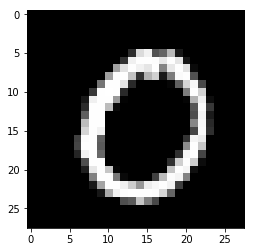

In [24]:
# example input image in test set 
plt.imshow(X_test[101,:,:,0],cmap='Greys_r')

In [25]:
# compute activations in conv layer 1 to the test set 
conv1_act = session.run(conv1,feed_dict=feed_dict)
conv1_act.shape

(10000, 28, 28, 32)

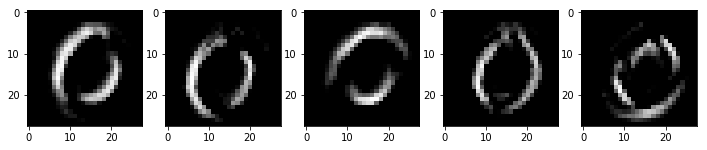

In [26]:
# plot different filter response to the same image 
util.plot_across([conv1_act[101,:,:,i] for i in range(5)])


In [27]:
tf.all_variables()

Instructions for updating:
Please use tf.global_variables instead.


[<tf.Variable 'conv2d/kernel:0' shape=(5, 5, 1, 32) dtype=float32_ref>,
 <tf.Variable 'conv2d/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'conv2d_1/kernel:0' shape=(5, 5, 32, 32) dtype=float32_ref>,
 <tf.Variable 'conv2d_1/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'dense/kernel:0' shape=(1568, 1024) dtype=float32_ref>,
 <tf.Variable 'dense/bias:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'dense_1/kernel:0' shape=(1024, 10) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'conv2d/kernel/Adam:0' shape=(5, 5, 1, 32) dtype=float32_ref>,
 <tf.Variable 'conv2d/kernel/Adam_1:0' shape=(5, 5, 1, 32) dtype=float32_ref>,
 <tf.Variable 'conv2d/bias/Adam:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'conv2d/bias/Adam_1:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'conv2d_1/kernel/Adam:0' shape=(5, 5,

In [34]:
gr = tf.get_default_graph()
#conv1_kernel_val = gr.get_tensor_by_name('conv2d/kernel:0').eval()
conv1_kernel_val2 = gr.get_tensor_by_name('conv2d/kernel/Adam:0').eval()


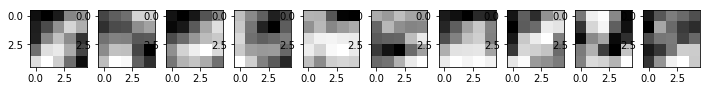

In [35]:
# plot filters 
util.plot_across([conv1_kernel_val2[:,:,0,i] for i in range(10)])


In [30]:
# Conv Layer 2
conv2_act= session.run(conv2,feed_dict=feed_dict)
conv2_act.shape

(10000, 14, 14, 32)

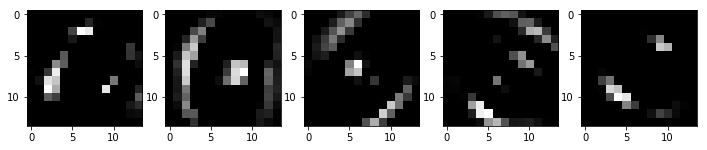

In [31]:
# plot different filter response to the same image in conv layer 2
util.plot_across([conv2_act[101,:,:,i] for i in range(5)])


In [36]:
conv2_kernel_val = gr.get_tensor_by_name('conv2d_1/kernel:0').eval()
conv2_kernel_val2 = gr.get_tensor_by_name('conv2d_1/kernel/Adam:0').eval()


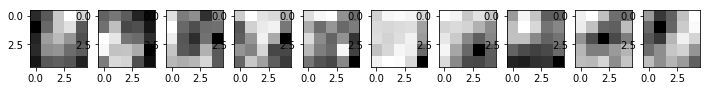

In [37]:
# plot filters 
util.plot_across([conv2_kernel_val2[:,:,0,i] for i in range(10)])


In [38]:
# get the second pooling layer 
pool2_act= session.run(pool2,feed_dict=feed_dict)
pool2_act.shape

(10000, 7, 7, 32)

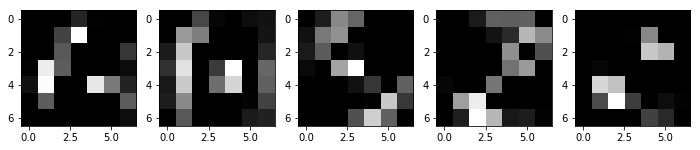

In [39]:
# plot different filter response to the same image in conv layer 2
util.plot_across([pool2_act[101,:,:,i] for i in range(5)])


In [40]:
# get the dense layer activation 
dense_act = session.run(dense,feed_dict=feed_dict)

In [41]:
dense_act.shape

(10000, 1024)

In [42]:
# get the logits 
logits_act = session.run(logits,feed_dict=feed_dict)

In [43]:
logits_act.shape

(10000, 10)

In [44]:
# print the category guesss 
np.argmax(logits_act[101,:])

0

# Filters from a Larger, Fully Trained Network

https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

## Keras
- Official wrapper for tensorflow. 
- easier to get up and running.
- Faster training for this example... (adam?)
- Harder to peak under the hood 

In [45]:
# Building the same network in Keras 
model = Sequential()
model.add(Conv2D(32, 5, 5, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2],1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, 5, 5, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

/Users/chris/anaconda/envs/env_class_deepRL/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), input_shape=(28, 28, 1..., activation="relu")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chris/anaconda/envs/env_class_deepRL/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu")`
  """


In [46]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [47]:
model.fit(X_train, Y_train, 
          batch_size=100, nb_epoch=1, verbose=1)

/Users/chris/anaconda/envs/env_class_deepRL/lib/python3.5/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/1
60000/60000 [==============================] - 34s - loss: 0.1931 - acc: 0.9428    


In [48]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test Loss, Test Accuracy')
print(score)

Test Loss, Test Accuracy
[0.058448948549665508, 0.98060000000000003]


In [49]:
# testing by hand (I didn't trust the score)
predictions = model.predict(np.squeeze(X_test)[0:100,:,:,np.newaxis])


In [50]:
np.mean(np.equal(np.argmax(Y_test[0:100],axis=1),np.argmax(predictions,axis=1)))

0.98999999999999999

In [ ]:
tf.all_variables()

# DataSet - Cats v Dogs

https://www.kaggle.com/c/dogs-vs-cats/data

In [51]:
# importing the data
path = '../data_cats_dogs/'

# listing the different classes of fish
os.listdir(path)

# get the paths for 900 cats and 900 dogs 
imgs_cats = glob.glob(path+'/cat.[0-9][0-9][0-9].jpg') # limits us to 900 images
imgs_dogs = glob.glob(path+'/dog.[0-9][0-9][0-9].jpg') # limits us to 900 images
print(len(imgs_dogs))

900


In [52]:
# keras comes with a nice image loading function 
# make the image size 64x64 for faster training 
img = image.load_img(imgs_cats[10], target_size=(64, 64))  
np.shape(img)

(64, 64, 3)

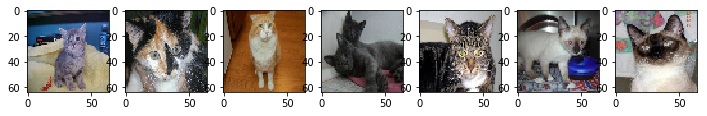

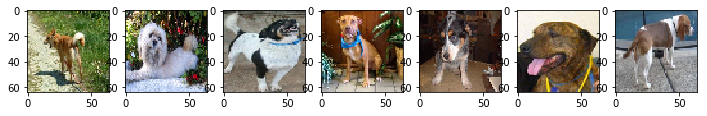

In [53]:
# visualizing the training data
plt.figure(figsize=(12,3))
for i in range(7):
    img = image.load_img(imgs_cats[np.random.randint(len(imgs_cats))], target_size=(64, 64))    
    plt.subplot(1,7,i+1)
    plt.imshow(img)
    plt.grid(b=False)
    
plt.figure(figsize=(12,3))
for i in range(7):
    img = image.load_img(imgs_dogs[np.random.randint(len(imgs_dogs))], target_size=(64, 64))    
    plt.subplot(1,7,i+1)
    plt.imshow(img)
    plt.grid(b=False)

In [54]:
Load image data to store in tensor (slow...)
for i,img in enumerate(imgs_cats+imgs_dogs):
    img = image.load_img(imgs_dogs[np.random.randint(len(imgs_dogs))], target_size=(64, 64)) 
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    if i==0:
        X = x
    else:
        X = np.concatenate((X,x),axis=0)

# save out 
np.save('./tmp_data/cats_dogs_900_X.npy',X)


SyntaxError: invalid syntax (<ipython-input-54-90d96ecf87d2>, line 1)

In [ ]:
# load back in 
X = np.load('./tmp_data/cats_dogs_900_X.npy')
print(np.shape(X))

In [ ]:
# convert to gray scale 
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

Xg = rgb2gray(X)
Xg=np.expand_dims(Xg, axis=3)
print(np.shape(Xg))

In [ ]:
plt.imshow(Xg[12,:,:,0],cmap='Greys_r',interpolation='nearest')

In [ ]:
# create labels 
y = np.append(np.ones(len(imgs_cats)),np.zeros(len(imgs_dogs)))
print(np.shape(y))

In [ ]:
# one-hot code the y data
Y = np_utils.to_categorical(y,2)
print(Y.shape)

In [ ]:
# normalize images so nnets work better
print('mean pixel intensity for single image {0}'.format(Xg[0,:,:].mean()))
Xg /= 255
print('mean pixel intensity for single image {0}'.format(Xg[0,:,:].mean()))

In [ ]:
# split into training and test set 
X_train, X_test, Y_train, Y_test = train_test_split(Xg, Y, test_size=0.33, random_state=42)
print(X_train.shape)

## ... to be continued 

## Convolution in 1-D 


... as a mathematical operation

$$ (s*k)(t) = \int_{\tau} s(\tau) k(\tau - t) $$ 



In [ ]:
from IPython.display import Image
Image(filename="./imgs/conv_box.gif.png")


# References

- Tutoral on Convolution (Charles Frye here in the Redwood Center)
- https://www.tensorflow.org/tutorials/layers
- http://cs231n.github.io/
- https://elitedatascience.com/keras-tutorial-deep-learning-in-python